Transfer Learning RS126 and Kinase dataset using classic ML models


***Summary:***

The code contains Transfer Learning Model trained on RS125 dataset and testing on kinase dataset using DT, RF, XGBoost, SVM, LR , KNN, and NB models.

1. Datacleaning, AAindex property extraction

2. Feature selection (DT, RF, XGBoost)

3. Padding of sequences

4. PCA (reduced features to 8)

5. Feature importance

5. SMOTE (for minority clas)

4. Model training and testing

5. Model evaluation

6. Stratified KFold Cross_validation

7. Classification_report

8. Confusion matrix

9. Matrices: Accuracy score, Precision, Recall, F1 score, MCC

10. Model Accuracy vs CV accuracy comparision plot

11. Model Comparision on Matrices: Accuracy score,

12. Precision, Recall, F1 score, MCC plots

13. Confidence Interval (CI) and McNemar’s Test Function

13. ROC by One-vs-Rest (OvR) % Interpretation of results

## Kinase testing on a completely independent dataset — which is better for generalization check
Generalization Check = Testing on a dataset that is not seen during training and ideally from a different distribution

In [ ]:
### RS126 DATASET ###
# read csv file
import pandas as pd
import numpy as np
df = pd.read_csv('RS126_to.csv')
df.head()

,input,dssp3
0,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...
1,CSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNW...,CCEEEECCCCCCCCCCCEECCCCCCEEEEEEECCCCCCCCCCCECC...
2,NVYHDGACPEVKPVDNFDWSNYHGKWWEVAKYPNSVEKYGKCGWAE...,CEEEECCCCCCCCCCCCCHHHCCEEEEEEEECCCCCCCCCEEEEEE...
3,AAPCFCSGKPGRGDLWILRGTCPGGYGYTSNCYKWPNICCYPH,CCCCCCCCCCCCCEEECCCCCCCCCCCCCCEEEECCEEEECCC
4,SISQQTVWNQMATVRTPLNFDSSKQSFCQFSVDLLGGGISVDKTGD...,CCCCCCCCEEEEEEECCCCCCCCCCCEEEEEEECCCCEEECCCCCC...


In [ ]:
### KINASE DATASET ####
# read csv file kinase
df2 = pd.read_csv('kinase.csv')

# drop PDB_ID, DSSP_Q8, Length coloumns
df2 = df2.drop(columns=['PDB_ID', 'DSSP_Q8', 'Length'])

# rename coloums from "Primary_Sequence" to "input" , "DSSP_Q3" to "dssp3" 
df2 = df2.rename(columns={'Primary_Sequence': 'input', 'DSSP_Q3': 'dssp3'})
df2.head()

,input,dssp3
0,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...,CCCEHHHCCCCCCEEEEECCCCCCEECCEECCCHHHHHHHHHHHHH...
1,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...,CECEHHHCCCCCCEEEEEECCCCCEECCEECCCHHHHHHHHHHHHH...
2,WKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKEN...,CEECCCHHHCEEEEEECECHHHHHEEEEEECCCCCEEEEEEEECCH...
3,LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGW...,CEEECCCECCCCCCECCECCCCEEEEEEECCCCCEEEEEECCEEEE...
4,NNGLTPQELEAYGISDVHDIVYNPSYDLLYQEELDPSLTGYERGVL...,CCCCCHHHHHHHCCCCCCCEEECCCHHHHHHHHCCCCCCHHHCCEE...


In [ ]:
### Remove Unequal-Length Sequences for RS126

# Check lengths and filter
df_cleaned = df[df['input'].str.len() == df['dssp3'].str.len()]

removed = len(df) - len(df_cleaned)
print(f"Cleaned DataFrame for RS126 created. Removed {removed} mismatched entries.")

### Remove Unequal-Length Sequences for Kinase

# Check lengths and filter
df2_cleaned = df2[df2['input'].str.len() == df2['dssp3'].str.len()]

removed2 = len(df2) - len(df2_cleaned)
print(f"Cleaned DataFrame for Kinase created. Removed {removed2} mismatched entries.")

Cleaned DataFrame for RS126 created. Removed 1 mismatched entries.
Cleaned DataFrame for Kinase created. Removed 0 mismatched entries.


In [4]:
# Calculate the maximum sequence length in RS126
max_len = df_cleaned['input'].str.len().max()
print(f" Maximum sequence length in RS126: {max_len}")

# Calculate the maximum sequence length in Kinase
max_len2 = df2_cleaned['input'].str.len().max()
print(f" Maximum sequence length in Kinase: {max_len2}")

 Maximum sequence length in RS126: 498
 Maximum sequence length in Kinase: 2160


In [5]:
pip install aaindex

Note: you may need to restart the kernel to use updated packages.


In [6]:
## Retrieving selected physicochemical properties from the AAindex1 database and creating a feature table for each amino acid
from aaindex import aaindex1
import pandas as pd

# Corrected property IDs
selected_ids = {
    'Helix Propensity': 'CHOC760101',
    'Charge': 'FAUJ880113',
    'Solvent Accessibility':'CORJ870101',
    'Isoelectric Point': 'ZIMJ680104',
    'Hydrophobicity': 'KYTJ820101',
    'Polarity': 'GRAR740102',
    'Helix Propensity':'CHOC760101',
    'Beta Sheet Propensity':'CHOC760102',
    'Turn Propensity': 'CHOC760103',
    'Hydrogen Bonding':'FAUJ880111',
    'Interaction Energy':'KANM800101',
    'Protein Stability':'TAKK010101',
    'Biological Activity':'ISOY800106',
    'Antigenicity':'WERD780101',
    'Electronegativity':'CHAM830107',
    'Refractivity':'ZIMJ680105',
    'Mass':'FAUJ880108',
    'Surface Tension':'RADA880108',
    'Van der Waals Volume':'FAUJ880103',
    'Bulkiness':'ZIMJ680101',
    'Compressibility':'FAUJ880106'
}

# Validate
for name, idx in selected_ids.items():
    if idx not in aaindex1.record_codes():
        raise ValueError(f"{name} → {idx} not found in aaindex1")

# Extract features
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
aa_features = pd.DataFrame(index=amino_acids)

for name, idx in selected_ids.items():
    aa_features[name] = [aaindex1[idx].values[aa] for aa in amino_acids]

print(aa_features.head())


   Helix Propensity  Charge  Solvent Accessibility  Isoelectric Point  \
A             115.0    4.76                  50.76               6.00   
C             135.0    3.67                  58.74               5.05   
D             150.0    5.69                  43.17               2.77   
E             190.0    5.48                  43.48               3.22   
F             210.0    4.31                  53.45               5.48   

   Hydrophobicity  Polarity  Beta Sheet Propensity  Turn Propensity  \
A             1.8       8.1                   25.0             0.38   
C             2.5       5.5                   19.0             0.45   
D            -3.5      13.0                   50.0             0.15   
E            -3.5      12.3                   49.0             0.18   
F             2.8       5.2                   24.0             0.50   

   Hydrogen Bonding  Interaction Energy  Protein Stability  \
A               0.0                1.36                9.8   
C         

In [ ]:
### PCA Loadings → Select Top 8 Raw Features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features

scaler_all = StandardScaler()
X_scaled_all = scaler_all.fit_transform(aa_features.values)

## Apply PCA on AAindex Features
pca_all = PCA(n_components=8) # PCA:reduces dimensionality from 20 → 8, retaining ~99% variance.
pca_all.fit(X_scaled_all)

loadings = pd.DataFrame(pca_all.components_.T, index=aa_features.columns, columns=[f'PC{i+1}' for i in range(8)])
abs_loadings = loadings.abs()
combined = abs_loadings[['PC1', 'PC2', 'PC3']].sum(axis=1).sort_values(ascending=False)


top_features = combined.head(8).index.tolist()
print("Top features selected:", top_features)


### Selected Only Top 8 Raw Features
aa_features_reduced = aa_features[top_features]


Top features selected: ['Helix Propensity', 'Van der Waals Volume', 'Charge', 'Electronegativity', 'Isoelectric Point', 'Compressibility', 'Beta Sheet Propensity', 'Turn Propensity']


In [8]:
aa_features_reduced.head()

,Helix Propensity,Van der Waals Volume,Charge,Electronegativity,Isoelectric Point,Compressibility,Beta Sheet Propensity,Turn Propensity
A,115.0,1.00,4.76,0.0,6.00,2.04,25.0,0.38
C,135.0,2.43,3.67,0.0,5.05,3.41,19.0,0.45
D,150.0,2.78,5.69,1.0,2.77,3.78,50.0,0.15
E,190.0,3.78,5.48,1.0,3.22,3.31,49.0,0.18
F,210.0,5.89,4.31,0.0,5.48,6.02,24.0,0.50


In [9]:
# sequence_to_features() Function

import numpy as np

def sequence_to_features(seq, aa_features):
    features = []
    for aa in seq:
        if aa in aa_features.index:
            features.append(aa_features.loc[aa].values)
        else:
            features.append(np.zeros(aa_features.shape[1]))  # fallback for unknown AAs
    return np.array(features)


In [ ]:
# Defined Padding Length and Feature Count
#  MAX_LEN for Padding/Truncating

MAX_LEN = df_cleaned['input'].str.len().max() ## max-length for RS126 is 498

X = []
y = []

for _, row in df_cleaned.iterrows():
    seq = row['input']
    labels = row['dssp3']

    # Sequence to feature matrix
    features = sequence_to_features(seq, aa_features_reduced)

    # Pad/truncate features
    if len(seq) < MAX_LEN:
        features = np.pad(features, ((0, MAX_LEN - len(seq)), (0, 0)), mode='constant')
    else:
        features = features[:MAX_LEN]

    # Pad/truncate labels
    padded_labels = labels.ljust(MAX_LEN, 'C')[:MAX_LEN]

    X.append(features)
    y.append(list(padded_labels))

X = np.array(X)
y = np.array(y)

print(f"Rs126 X shape: {X.shape}, RS126 y shape: {y.shape}")


Rs126 X shape: (125, 498, 8), RS126 y shape: (125, 498)


In [11]:
## Convert character labels ('C', 'H', 'E') into numerical form (0, 1, 2) for machine learning models.

# Label Encoding (y)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(['C', 'H', 'E'])

y_encoded = label_encoder.transform(y.flatten()).reshape(y.shape)
print(f"RS126 y_encoded shape: {y_encoded.shape}")


RS126 y_encoded shape: (125, 498)


In [ ]:
# Flatten X and y
X_flat = X.reshape(-1, X.shape[-1])  # shape: (total_residues, 8)
y_flat = y_encoded.flatten()

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_flat)
y_train_std = y_flat



## SMOTE (Synthetic Minority Oversampling Technique) to balanced all labels
# Applyed SMOTE only for X and y training sets not testing sets.
# Balances the training set by synthetically oversampling underrepresented classes (e.g., E or H).

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_std, y_train_std)

print(f"X_train shape (RS126) = {X_train.shape}, y_train shape (RS126) = {y_train.shape}")


X_train shape (RS126) = (149538, 8), y_train shape (RS126) = (149538,)


In [13]:
# Count label clases before and after SMOTE for RS126 data class balance

from collections import Counter
print("RS126 Before SMOTE:", Counter(y_train_std))
print("RS126 After SMOTE:", Counter(y_train))


RS126 Before SMOTE: Counter({0: 49846, 2: 7157, 1: 5247})
RS126 After SMOTE: Counter({0: 49846, 1: 49846, 2: 49846})


In [ ]:
##  Mapping in Code
for label, name in enumerate(label_encoder.classes_):
    print(f"{label} → {name}")


0 → C
1 → E
2 → H


In [15]:
# Process Kinase Data → X_test, y_test
# similar steps for df2_cleaned (kinase):
# MAX_LEN same as RS126

X_kinase = []
y_kinase = []

for _, row in df2_cleaned.iterrows():
    seq = row['input']
    labels = row['dssp3']

    features = sequence_to_features(seq, aa_features_reduced)

    if len(seq) < MAX_LEN:
        features = np.pad(features, ((0, MAX_LEN - len(seq)), (0, 0)), mode='constant')
    else:
        features = features[:MAX_LEN]

    padded_labels = labels.ljust(MAX_LEN, 'C')[:MAX_LEN]

    X_kinase.append(features)
    y_kinase.append(list(padded_labels))

X_kinase = np.array(X_kinase)
y_kinase = np.array(y_kinase)

print(f"Kinase X shape: {X_kinase.shape}, Kinase y shape: {y_kinase.shape}")

Kinase X shape: (50, 498, 8), Kinase y shape: (50, 498)


In [16]:
# Label encode and flatten for Kinase data
y_kinase_encoded = label_encoder.transform(y_kinase.flatten()).reshape(y_kinase.shape)
print(f"Kinase y_encoded shape: {y_kinase_encoded.shape}")

Kinase y_encoded shape: (50, 498)


In [17]:
X_test = X_kinase.reshape(-1, X_kinase.shape[-1])
y_test = y_kinase_encoded.flatten()

# Use same scaler from RS126
X_test = scaler.transform(X_test)

print(f"Kinase: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

Kinase: X_test shape = (24900, 8), y_test shape = (24900,)


In [18]:
from collections import Counter

# for RS126
all_labels = y_train_std.flatten() # contains labels count before SMOTE
label_counts = Counter(all_labels)

# map back to original class names
label_mapping = {0: 'C', 1: 'H', 2: 'E'}
mapped_counts = {label_mapping[k]: v for k, v in label_counts.items()}

print("Counts for RS126",mapped_counts)

# for Kinase
all_labels_kinase = y_test.flatten()
label_counts_kinase = Counter(all_labels_kinase)

# map back to original class names
label_mapping_kinase = {0: 'C', 1: 'H', 2: 'E'}
mapped_counts_kinase = {label_mapping_kinase[k]: v for k, v in label_counts_kinase.items()}
print("Counts for Kinase",mapped_counts_kinase)

Counts for RS126 {'C': 49846, 'H': 5247, 'E': 7157}
Counts for Kinase {'C': 14550, 'H': 3456, 'E': 6894}


In [19]:
### import necessary libraries

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt


========== MultinomialNB ==========
 Skipped MultinomialNB (requires non-negative features)

========== Decision Tree ==========
 Accuracy         : 53.44%
 Precision (macro): 55.36%
 Recall (macro)   : 54.57%
 F1 Score (macro) : 49.78%
 MCC Score        : 0.35

 Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.50      0.66     14550
           E       0.24      0.52      0.32      3456
           H       0.43      0.62      0.50      6894

    accuracy                           0.53     24900
   macro avg       0.55      0.55      0.50     24900
weighted avg       0.73      0.53      0.57     24900


 Cross-validation scores (accuracy %): [67.32, 66.64, 66.97, 66.99, 67.36]
 Mean CV Accuracy   : 67.06%
 Std Dev CV Accuracy: 0.26%


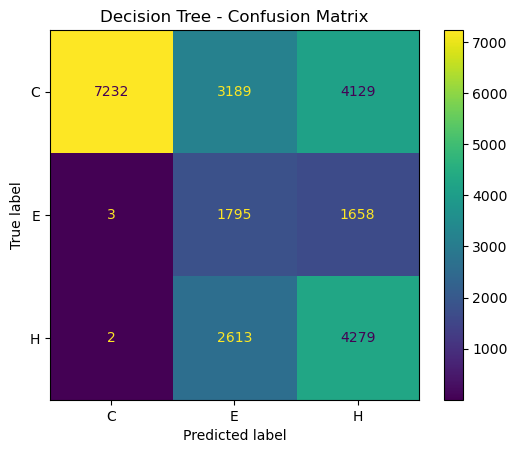


========== Random Forest ==========
 Accuracy         : 53.44%
 Precision (macro): 55.36%
 Recall (macro)   : 54.57%
 F1 Score (macro) : 49.78%
 MCC Score        : 0.35

 Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.50      0.66     14550
           E       0.24      0.52      0.32      3456
           H       0.43      0.62      0.50      6894

    accuracy                           0.53     24900
   macro avg       0.55      0.55      0.50     24900
weighted avg       0.73      0.53      0.57     24900


 Cross-validation scores (accuracy %): [67.32, 66.64, 66.97, 66.99, 67.36]
 Mean CV Accuracy   : 67.06%
 Std Dev CV Accuracy: 0.26%


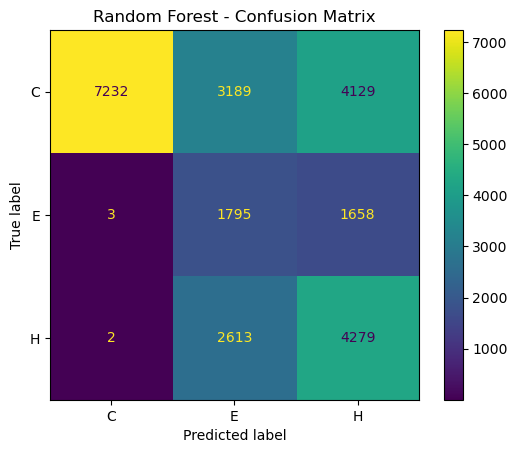


========== XGBoost ==========
 Accuracy         : 53.44%
 Precision (macro): 55.36%
 Recall (macro)   : 54.57%
 F1 Score (macro) : 49.78%
 MCC Score        : 0.35

 Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.50      0.66     14550
           E       0.24      0.52      0.32      3456
           H       0.43      0.62      0.50      6894

    accuracy                           0.53     24900
   macro avg       0.55      0.55      0.50     24900
weighted avg       0.73      0.53      0.57     24900


 Cross-validation scores (accuracy %): [67.32, 66.64, 66.97, 66.99, 67.36]
 Mean CV Accuracy   : 67.06%
 Std Dev CV Accuracy: 0.26%


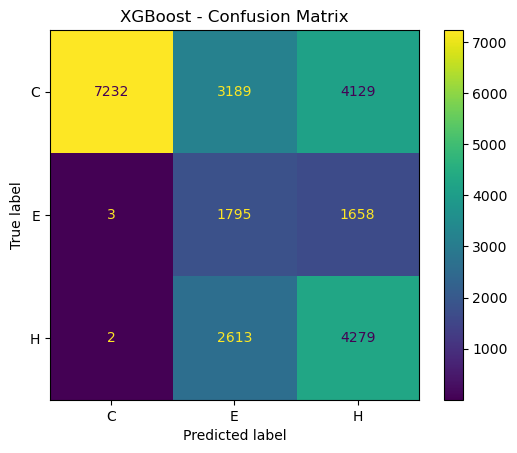


========== Logistic Regression ==========
 Accuracy         : 51.10%
 Precision (macro): 54.72%
 Recall (macro)   : 53.82%
 F1 Score (macro) : 48.08%
 MCC Score        : 0.33

 Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.50      0.66     14550
           E       0.23      0.64      0.34      3456
           H       0.42      0.47      0.44      6894

    accuracy                           0.51     24900
   macro avg       0.55      0.54      0.48     24900
weighted avg       0.73      0.51      0.56     24900


 Cross-validation scores (accuracy %): [65.77, 65.49, 65.64, 65.5, 65.79]
 Mean CV Accuracy   : 65.64%
 Std Dev CV Accuracy: 0.13%


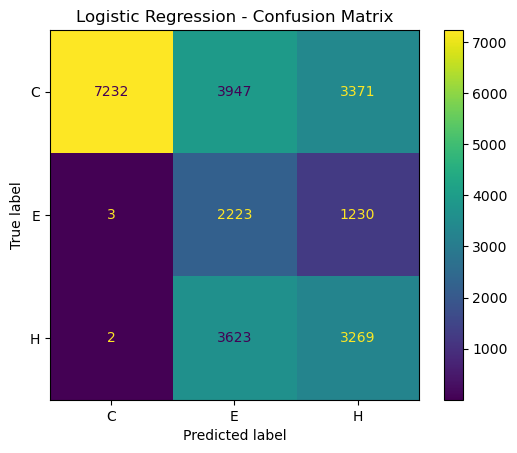


========== SVM (Linear Kernel) ==========
 Accuracy         : 52.62%
 Precision (macro): 54.94%
 Recall (macro)   : 54.34%
 F1 Score (macro) : 49.27%
 MCC Score        : 0.33

 Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.50      0.66     14550
           E       0.25      0.56      0.34      3456
           H       0.40      0.57      0.47      6894

    accuracy                           0.53     24900
   macro avg       0.55      0.54      0.49     24900
weighted avg       0.73      0.53      0.57     24900


 Cross-validation scores (accuracy %): [64.14, 64.11, 63.95, 64.24, 64.14]
 Mean CV Accuracy   : 64.12%
 Std Dev CV Accuracy: 0.09%


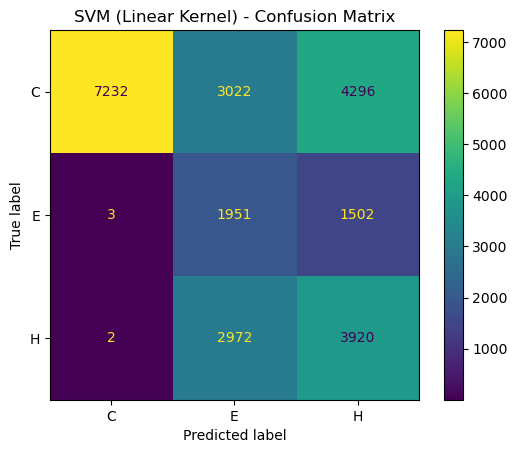


========== SVM (RBF Kernel) ==========
 Accuracy         : 53.44%
 Precision (macro): 55.36%
 Recall (macro)   : 54.57%
 F1 Score (macro) : 49.78%
 MCC Score        : 0.35

 Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.50      0.66     14550
           E       0.24      0.52      0.32      3456
           H       0.43      0.62      0.50      6894

    accuracy                           0.53     24900
   macro avg       0.55      0.55      0.50     24900
weighted avg       0.73      0.53      0.57     24900


 Cross-validation scores (accuracy %): [67.32, 66.64, 66.97, 66.99, 67.36]
 Mean CV Accuracy   : 67.06%
 Std Dev CV Accuracy: 0.26%


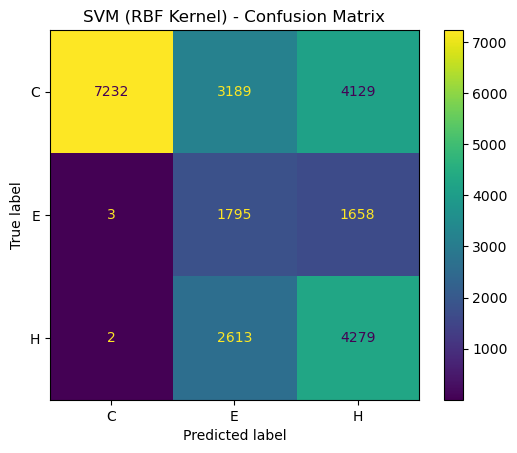


========== K-Nearest Neighbors ==========
 Accuracy         : 57.08%
 Precision (macro): 30.74%
 Recall (macro)   : 43.11%
 F1 Score (macro) : 35.86%
 MCC Score        : 0.19

 Classification Report:
              precision    recall  f1-score   support

           C       0.65      0.88      0.75     14550
           E       0.27      0.42      0.33      3456
           H       0.00      0.00      0.00      6894

    accuracy                           0.57     24900
   macro avg       0.31      0.43      0.36     24900
weighted avg       0.42      0.57      0.48     24900


 Cross-validation scores (accuracy %): [47.06, 49.51, 50.0, 48.56, 48.95]
 Mean CV Accuracy   : 48.82%
 Std Dev CV Accuracy: 1.00%


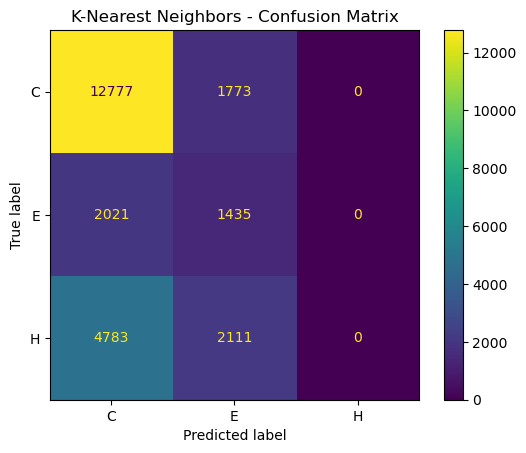

In [ ]:

# ===== Defined Models with Class Weights Where Applicable =====
models = {
    "MultinomialNB": MultinomialNB(),  # Only if features are non-negative
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),  # No class_weight here (SMOTE already balances)
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),  # Handles imbalance internally with `scale_pos_weight`
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM (Linear Kernel)": SVC(kernel='linear', class_weight='balanced'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance')  # No class_weight support
}

# ===== Cross-Validation Setup =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# ===== Training and Evaluation =====
for model_name, model in models.items():
    print(f"\n========== {model_name} ==========")

    # Skiped MultinomialNB because features are negative
    if model_name == "MultinomialNB" and np.any(X_train < 0):
        print(" Skipped MultinomialNB (requires non-negative features)")
        continue

    # === Train model and evaluate on test set ===
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f" Accuracy         : {acc * 100:.2f}%")
    print(f" Precision (macro): {prec * 100:.2f}%")
    print(f" Recall (macro)   : {rec * 100:.2f}%")
    print(f" F1 Score (macro) : {f1 * 100:.2f}%")
    print(f" MCC Score        : {mcc:.2f}")

    # === Classification Report ===
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_,zero_division=0))

    # === Stratified Cross-Validation ===
    cv_accuracies = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        fold_acc = accuracy_score(y_fold_val, y_fold_pred)
        cv_accuracies.append(fold_acc * 100)

    cv_accuracies = np.array(cv_accuracies)
    print(f"\n Cross-validation scores (accuracy %): {np.round(cv_accuracies, 2).tolist()}")
    print(f" Mean CV Accuracy   : {cv_accuracies.mean():.2f}%")
    print(f" Std Dev CV Accuracy: {cv_accuracies.std():.2f}%")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': acc * 100,
        'Precision': prec * 100,
        'Recall': rec * 100,
        'F1 Score': f1 * 100,
        'MCC': mcc,
        'CV Accuracy Mean': cv_accuracies.mean(),
        'CV Accuracy Std Dev': cv_accuracies.std()
    })


In [21]:
# convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.round(2)
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,MCC,CV Accuracy Mean,CV Accuracy Std Dev
0,K-Nearest Neighbors,57.08,30.74,43.11,35.86,0.19,48.82,1.00
1,Random Forest,53.44,55.36,54.57,49.78,0.35,67.06,0.26
2,Decision Tree,53.44,55.36,54.57,49.78,0.35,67.06,0.26
3,XGBoost,53.44,55.36,54.57,49.78,0.35,67.06,0.26
4,SVM (RBF Kernel),53.44,55.36,54.57,49.78,0.35,67.06,0.26
5,SVM (Linear Kernel),52.62,54.94,54.34,49.27,0.33,64.12,0.09
6,Logistic Regression,51.10,54.72,53.82,48.08,0.33,65.64,0.13


In [22]:
# MCC as a Bar Chart using Plotly
import plotly.express as px

fig_mcc = px.bar(
    results_df,
    x='Model',
    y='MCC',
    title=' MCC Score by Model',
    text='MCC',
    color='MCC',
    color_continuous_scale='Viridis'
)
fig_mcc.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_mcc.update_layout(yaxis_title='MCC Score', xaxis_title='Model', showlegend=False)
fig_mcc.show()


In [ ]:
# Bar graphs model comparision
melted = results_df.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Accuracy Mean'],
    var_name='Metric',
    value_name='Score'
)

fig_all = px.bar(
    melted,
    x='Model',
    y='Score',
    color='Metric',
    barmode='group',
    text='Score',
    title=' Model Comparison Across Multiple Metrics'
)

fig_all.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_all.update_layout(
    yaxis_title='Score (%)',
    xaxis_title='Model',
    legend_title='Metric',
    xaxis_tickangle=-45
)
fig_all.show()


In [24]:
## Future importance plot

# Save fitted models explicitly so can access their feature_importances_
dt = models['Decision Tree']
rf = models['Random Forest']
xgb = models['XGBoost']

# Feature names used
feature_names = [
    'Hydrogen Bonding',
    'Electronegativity',
    'Mass',
    'Turn Propensity',
    'Beta Sheet Propensity',
    'Hydrophobicity',
    'Polarity',
    'Surface Tension'
]


# Extract feature importances
dt_importances = dt.feature_importances_
rf_importances = rf.feature_importances_
xgb_importances = xgb.feature_importances_


# Plot using Plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=feature_names,
    y=dt_importances,
    name='Decision Tree',
    marker_color='salmon'
))

fig.add_trace(go.Bar(
    x=feature_names,
    y=rf_importances,
    name='Random Forest',
    marker_color='skyblue'
))

fig.add_trace(go.Bar(
    x=feature_names,
    y=xgb_importances,
    name='XGBoost',
    marker_color='lightgreen'
))

fig.update_layout(
    title='Feature Importance: DT vs RF vs XGBoost (Selected 8 AAindex Features)',
    xaxis_title='AAindex Features',
    yaxis_title='Importance Score',
    barmode='group',
    template='plotly_white',
    width=900,
    height=500
)

fig.show()

Confidence Interval (CI)

A confidence interval gives a range of values that is likely to contain the true value of a metric (like accuracy), based on sample (test data).

It's used to express uncertainty in performance evaluation.

Adding confidence intervals and performing statistical tests like McNemar’s test helps to compare model performance, going beyond just raw accuracy or F1-scores.

These methods determine whether the performance differences between models are statistically significant or just due to random chance

In [25]:
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.contingency_tables import mcnemar

models = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),  # No class_weight here (SMOTE already balances)
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),  # Handles imbalance internally with `scale_pos_weight`, if needed
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM (Linear Kernel)": SVC(kernel='linear', class_weight='balanced'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance')  # No class_weight support
}


# Store evaluation results and predictions
results = []
predictions = {}
n = len(y_test)

# Train, predict, evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred  # for McNemar later

    acc = accuracy_score(y_test, y_pred)
    correct = int(acc * n)
    ci_low, ci_high = proportion_confint(count=correct, nobs=n, alpha=0.05, method='normal')

    precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro',zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': round(acc * 100, 2),
        '95% CI(Lower)': round(ci_low * 100, 2),
        '95% CI(Upper)': round(ci_high * 100, 2),
        'Precision(Macro)': round(precision * 100, 2),
        'Recall(Macro)': round(recall * 100, 2),
        'F1-Score(Macro)': round(f1_macro * 100, 2),
        'MCC': round(mcc, 2)
    })

# Create DataFrame
df_metrics = pd.DataFrame(results)

In [26]:
# Display metrics table
print("\n Final Metrics with 95% Confidence Intervals:\n")
df_metrics


 Final Metrics with 95% Confidence Intervals:



,Model,Accuracy,95% CI(Lower),95% CI(Upper),Precision(Macro),Recall(Macro),F1-Score(Macro),MCC
0,Decision Tree,53.44,52.82,54.06,55.36,54.57,49.78,0.35
1,Random Forest,53.44,52.82,54.06,55.36,54.57,49.78,0.35
2,XGBoost,53.44,52.82,54.06,55.36,54.57,49.78,0.35
3,Logistic Regression,51.10,50.48,51.72,54.72,53.82,48.08,0.33
4,SVM (Linear Kernel),52.62,52.00,53.24,54.94,54.34,49.27,0.33
5,SVM (RBF Kernel),53.44,52.82,54.06,55.36,54.57,49.78,0.35
6,K-Nearest Neighbors,57.08,56.46,57.69,30.74,43.11,35.86,0.19


In [27]:
##  McNemar’s Test Function

def mcnemar_test(pred1, pred2, y_true, name1, name2):
    b = np.sum((pred1 == y_true) & (pred2 != y_true))  # model1 correct, model2 wrong
    c = np.sum((pred1 != y_true) & (pred2 == y_true))  # model1 wrong, model2 correct
    table = [[0, b], [c, 0]]
    result = mcnemar(table, exact=True)

    print(f"\n{name1} vs {name2} → McNemar’s Test p-value: {result.pvalue:.4f}")
    if result.pvalue < 0.05:
        print("→ Statistically significant difference ")
    else:
        print("→ No significant difference ")


In [28]:
mcnemar_test(predictions['Random Forest'], predictions['XGBoost'], y_test, "Random Forest", "XGBoost")

mcnemar_test(predictions['Logistic Regression'], predictions['SVM (Linear Kernel)'], y_test, "Logistic Regression", "SVM (Linear Kernel)")

mcnemar_test(predictions['SVM (RBF Kernel)'], predictions['K-Nearest Neighbors'], y_test, "SVM (RBF Kernel)", "KNN")

mcnemar_test(predictions['Decision Tree'], predictions['XGBoost'], y_test, "Decision Tree", "XGBoost")


Random Forest vs XGBoost → McNemar’s Test p-value: 1.0000
→ No significant difference 

Logistic Regression vs SVM (Linear Kernel) → McNemar’s Test p-value: 0.0000
→ Statistically significant difference 

SVM (RBF Kernel) vs KNN → McNemar’s Test p-value: 0.0000
→ Statistically significant difference 

Decision Tree vs XGBoost → McNemar’s Test p-value: 1.0000
→ No significant difference 


In [29]:

##ROC curves for all models using the One-vs-Rest (OvR) approach for multi-class classification (e.g., Q3: C=0, H=1, E=2).
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
classes = [0, 1, 2]
class_labels = ['C', 'H', 'E']
class_colors = ['crimson', 'seagreen', 'royalblue']
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Initialize plotly figure
fig = go.Figure()

# Loop through models
for model_name, model in models.items():
    # Get decision scores or probabilities
    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            print(f"Skipping {model_name} (no predict_proba or decision_function)")
            continue
    except Exception as e:
        print(f"Skipping {model_name} due to error: {e}")
        continue

    # One-vs-Rest ROC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        fig.add_trace(go.Scatter(
            x=fpr,
            y=tpr,
            mode='lines',
            name=f"{model_name} – {class_labels[i]} (AUC={roc_auc:.2f})",
            line=dict(width=2),
            hovertemplate=f"Model: {model_name}<br>Class: {class_labels[i]}<br>AUC: {roc_auc:.2f}<extra></extra>"
        ))

# Diagonal reference line
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    showlegend=False
))

# Layout
fig.update_layout(
    title='Multi-Class ROC Curves per Model (One-vs-Rest)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=950,
    height=600,
    legend=dict(
        font=dict(size=11),
        orientation="v"
    ),
    template="plotly_white"
)

fig.show()
